# Data Visualization

#### Loading my data

In [22]:
import joblib
import pandas as pd

# Loading price data for usage
#
#save_path = r"C:\Users\Muhammad\Mini_Capstone_Project\data\f'{coin_id}_{vs_currency}_{days}d_{interval}_{datetime.now().strftime('%Y%m%d_%H%M%S')'}.joblib"
save_path = r'C:\Users\Muhammad\Mini_Capstone_Project\data\ethereum_usd_30d_daily_20250811_114953.joblib'
df_coingecko = joblib.load(save_path)
 

#Loading whale data for usage
df_whales = pd.read_csv(r"C:\Users\Muhammad\Mini_Capstone_Project\data\dune_whale_data\whale_data_20250811_114953.csv")

### Data Wrangling (with Pandas)
### Merge datasets on timestamp (hour/day)

In [23]:
# Reset index so 'timestamp' becomes a column again
df_coingecko.reset_index(inplace=True)

# Floor timestamp to daily to match whale data
df_coingecko["timestamp"] = df_coingecko["timestamp"].dt.floor("D")

#Making sure df_whales is also properly formatted
df_whales["timestamp"] = pd.to_datetime(df_whales["timestamp"]).dt.floor("D")

#Converting Both timestamps to naive datetime(dropping timezone)
df_whales["timestamp"] = pd.to_datetime(df_whales["timestamp"]).dt.tz_localize(None)
df_coingecko["timestamp"] = pd.to_datetime(df_coingecko["timestamp"]).dt.tz_localize(None)

#Merging both DataFrames
df_merged = pd.merge(df_whales, df_coingecko, on="timestamp",  how="inner")
df_merged.head()

,eth_amount,from_address,timestamp,to_address,tx_hash,usd_value,price
0,0.884424,0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1,2025-08-11,0x9e1fb8154a5fa882a8b4591134626ce67d89e49d,0xa8b031936bcdabf70d883cc1c019b679e9cb648f180c...,1.071372e+05,4253.591619
1,0.884424,0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1,2025-08-11,0x9e1fb8154a5fa882a8b4591134626ce67d89e49d,0xa8b031936bcdabf70d883cc1c019b679e9cb648f180c...,1.071372e+05,4245.615093
2,6.000000,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,2025-08-11,0x57f24c9c53213d138bcffeb364afa57d4d3f2ae6,0x4dd29f01c0e7f9d9752edb4ddf55c25b69625e678142...,7.268274e+05,4253.591619
3,6.000000,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,2025-08-11,0x57f24c9c53213d138bcffeb364afa57d4d3f2ae6,0x4dd29f01c0e7f9d9752edb4ddf55c25b69625e678142...,7.268274e+05,4245.615093
4,22.238338,0x97e9ef204c4709dbd6786178e7a36ea734da84fc,2025-08-11,0xba3cb449bd2b4adddbc894d8697f5170800eadec,0xe5603a284b0586939c743987b196a6cb293206c372ca...,2.693906e+06,4253.591619


## Feature Engineering

##### 1. Normalizing Whale Transfer Count or Volume

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
minmax_scaler = MinMaxScaler()
zscore_scaler = StandardScaler()

# Normalize ETH amount and USD value (Min-Max)
df_merged["eth_amount_norm"] = minmax_scaler.fit_transform(df_merged[["eth_amount"]])
df_merged["usd_value_norm"] = minmax_scaler.fit_transform(df_merged[["usd_value"]])

# Or Z-score normalization (uncomment if you prefer this)
# df_merged["eth_amount_zscore"] = zscore_scaler.fit_transform(df_merged[["eth_amount"]])
# df_merged["usd_value_zscore"] = zscore_scaler.fit_transform(df_merged[["usd_value"]])


##### 2. Compute Daily Price Change % or Price Volatility

In [25]:
# Sort by time just in case
df_merged = df_merged.sort_values("timestamp")

# Calculate % change in price (daily or hourly depending on data)
df_merged["price_change_pct"] = df_merged["price"].pct_change() * 100

# Calculate rolling price volatility (standard deviation over a window, e.g., 3-day)
df_merged["price_volatility"] = df_merged["price"].rolling(window=3).std()

##### 3. Create Flags for "Whale Spike" Periods
# Compute 95th percentile
threshold = df_merged["usd_value"].quantile(0.95)

# Create binary flag column
df_merged["whale_spike_flag"] = (df_merged["usd_value"] > threshold).astype(int)


print(df_merged[["timestamp", "eth_amount", "usd_value", "price", "price_change_pct", "price_volatility", "whale_spike_flag"]].tail(10))

      timestamp  eth_amount     usd_value        price  price_change_pct  \
664  2025-08-11   10.000000  1.212355e+06  4253.591619          0.187877   
663  2025-08-11    7.129120  8.643023e+05  4245.615093         -0.187524   
662  2025-08-11    7.129120  8.643023e+05  4253.591619          0.187877   
661  2025-08-11    5.200000  6.304245e+05  4245.615093         -0.187524   
660  2025-08-11    5.200000  6.304245e+05  4253.591619          0.187877   
659  2025-08-11    1.099945  1.333524e+05  4245.615093         -0.187524   
658  2025-08-11    1.099945  1.333524e+05  4253.591619          0.187877   
657  2025-08-11    1.519269  1.841893e+05  4245.615093         -0.187524   
670  2025-08-11    1.006525  1.220265e+05  4253.591619          0.187877   
1999 2025-08-11   59.000000  7.148113e+06  4245.615093         -0.187524   

      price_volatility  whale_spike_flag  
664           4.605249                 0  
663           4.605249                 0  
662           4.605249            

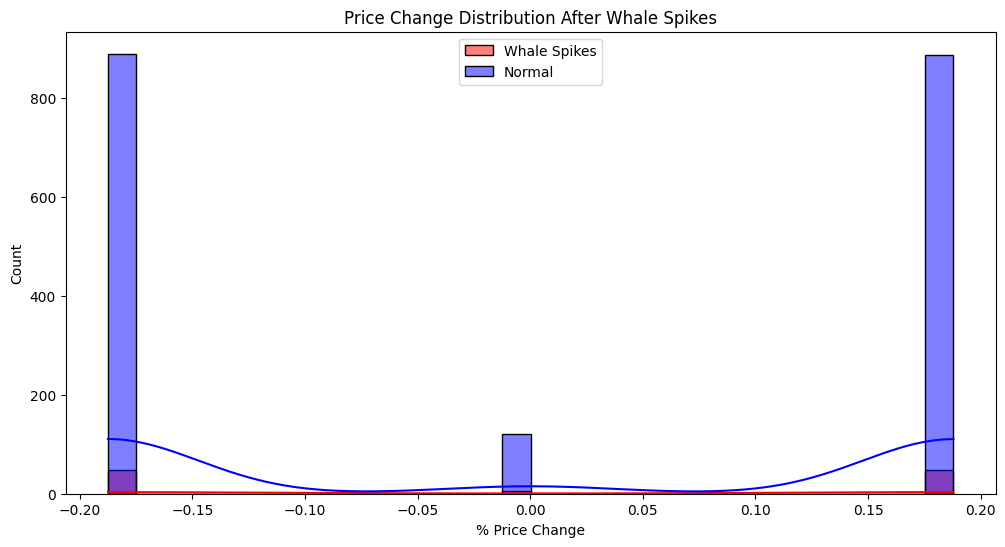

In [26]:
# Flag whale
import seaborn as sns
import matplotlib.pyplot as plt

# Whale spike flag: above 95th percentile
threshold = df_merged['usd_value'].quantile(0.95)
df_merged['whale_spike'] = df_merged['usd_value'] > threshold

# Histogram of price changes after whale spikes
plt.figure(figsize=(12, 6))
sns.histplot(df_merged[df_merged['whale_spike']]['price_change_pct'], bins=30, kde=True, color='red', label='Whale Spikes')
sns.histplot(df_merged[~df_merged['whale_spike']]['price_change_pct'], bins=30, kde=True, color='blue', label='Normal')
plt.title("Price Change Distribution After Whale Spikes")
plt.xlabel("% Price Change")
plt.legend()
plt.show()

### Exploratory Data Analysis (EDA)

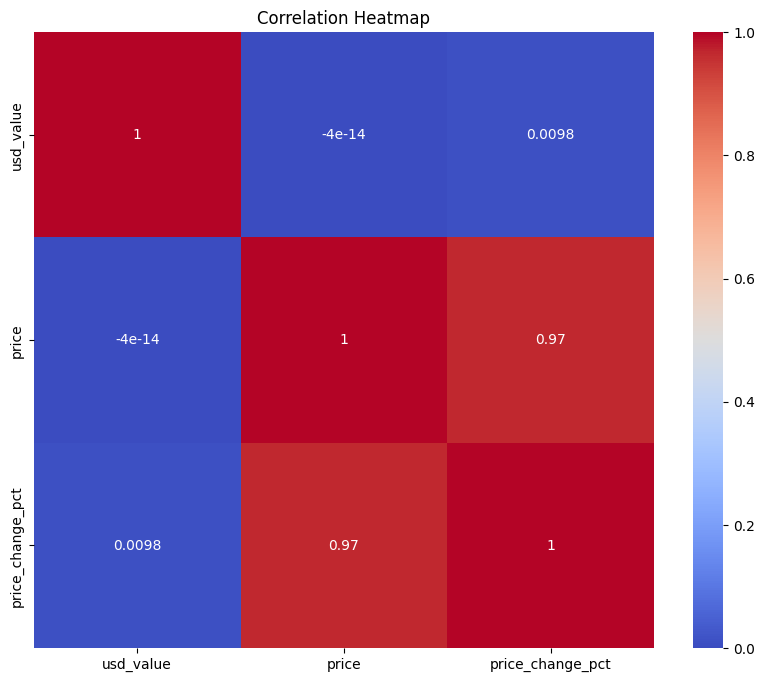

In [27]:
#Heatmap: To create a heatmap to visualize the relationship between whale activity and price movements

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_merged[['usd_value', 'price', 'price_change_pct']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

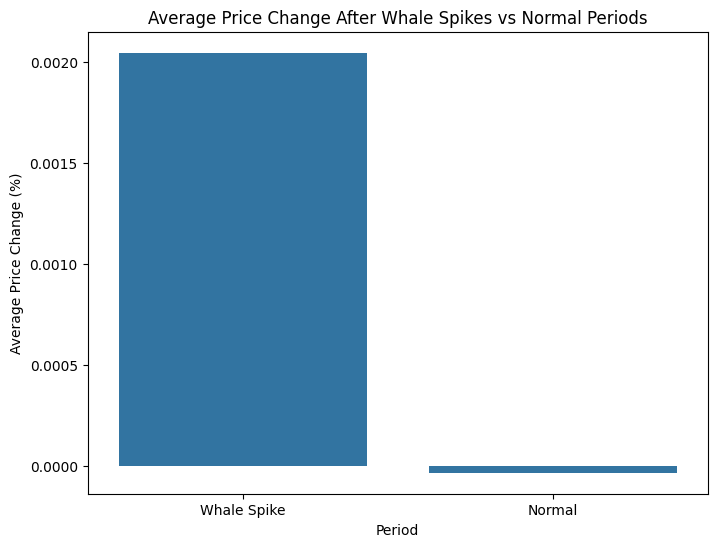

In [28]:
#Bar Chart: To create a bar chart to compare the average price change after whale spikes vs normal periods.

avg_price_change_whale = df_merged[df_merged['whale_spike_flag'] == 1]['price_change_pct'].mean()
avg_price_change_normal = df_merged[df_merged['whale_spike_flag'] == 0]['price_change_pct'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=['Whale Spike', 'Normal'], y=[avg_price_change_whale, avg_price_change_normal])
plt.title("Average Price Change After Whale Spikes vs Normal Periods")
plt.xlabel("Period")
plt.ylabel("Average Price Change (%)")
plt.show()

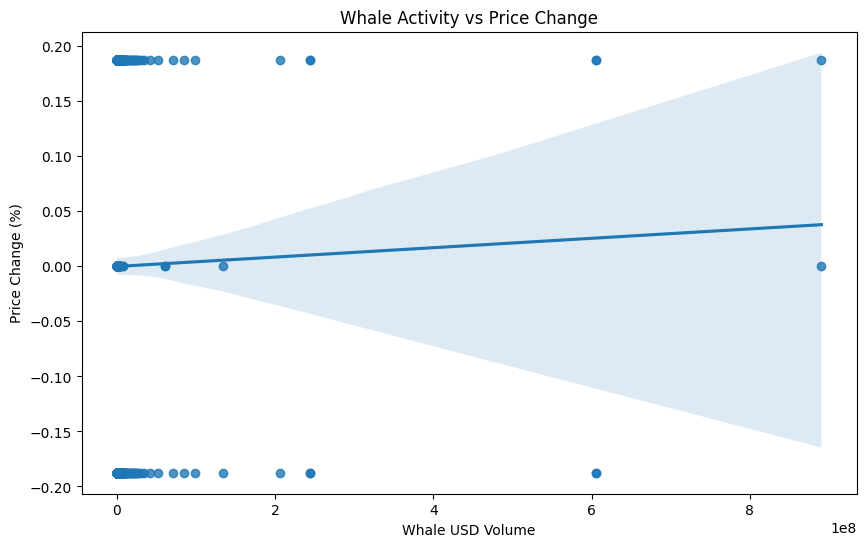

In [29]:
#Scatter Plot with Regression Line:To create a scatter plot with a regression line to visualize the relationship between whale activity and price movements.

plt.figure(figsize=(10, 6))
sns.regplot(x='usd_value', y='price_change_pct', data=df_merged)
plt.title("Whale Activity vs Price Change")
plt.xlabel("Whale USD Volume")
plt.ylabel("Price Change (%)")
plt.show()

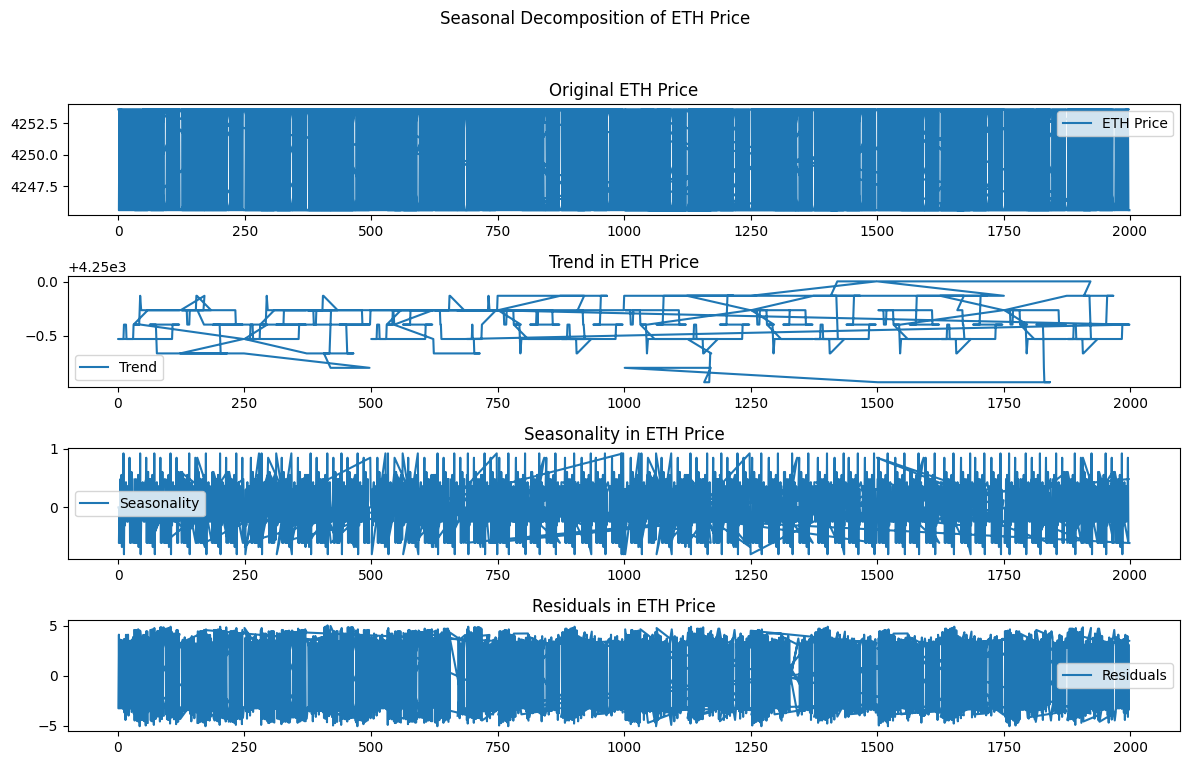

In [32]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose

# Time Series Decomposition
#decomposition = seasonal_decompose(df_merged['price'], model='additive')
decomposition = seasonal_decompose(df_merged['price'], model='additive', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4, 1, figsize=(12, 8))

axs[0].plot(df_merged['price'], label='ETH Price')
axs[0].legend(loc='best')
axs[0].set_title('Original ETH Price')

axs[1].plot(trend, label='Trend')
axs[1].legend(loc='best')
axs[1].set_title('Trend in ETH Price')

axs[2].plot(seasonal, label='Seasonality')
axs[2].legend(loc='best')
axs[2].set_title('Seasonality in ETH Price')

axs[3].plot(residual, label='Residuals')
axs[3].legend(loc='best')
axs[3].set_title('Residuals in ETH Price')

fig.suptitle('Seasonal Decomposition of ETH Price')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



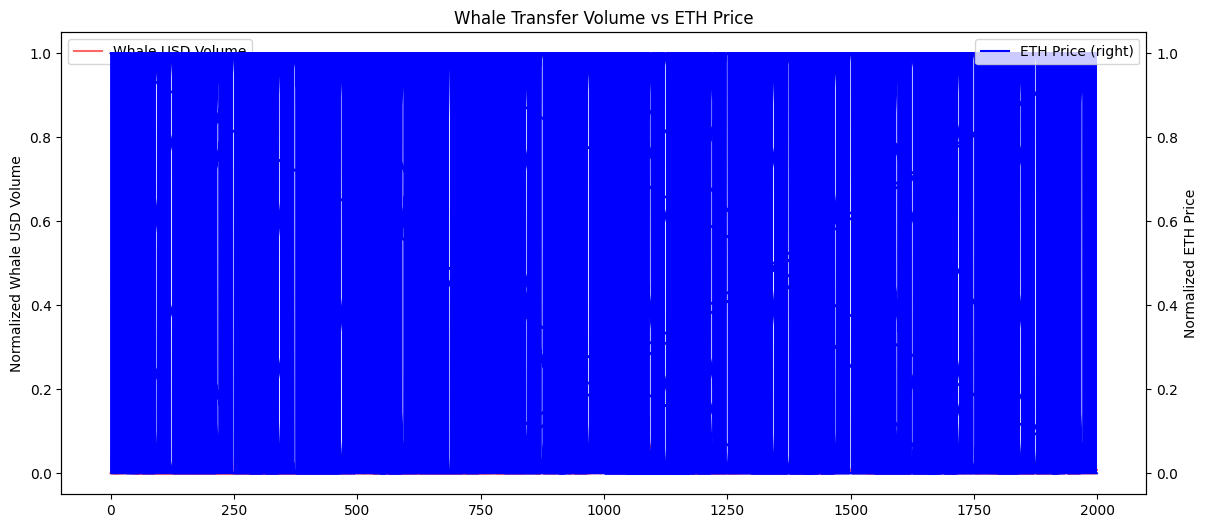

In [33]:

#Time Series Plots: Whale Activity vs Price

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_merged['usd_value_normalized'] = scaler.fit_transform(df_merged[['usd_value']])
df_merged['price_normalized'] = scaler.fit_transform(df_merged[['price']])

plt.figure(figsize=(14, 6))
ax1 = df_merged['usd_value_normalized'].plot(label='Whale USD Volume', color='red', alpha=0.6)
ax2 = df_merged['price_normalized'].plot(label='ETH Price', color='blue', secondary_y=True)
ax1.set_title("Whale Transfer Volume vs ETH Price")
ax1.set_ylabel("Normalized Whale USD Volume")
ax2.set_ylabel("Normalized ETH Price")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()